In [1]:
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from dotenv import load_dotenv
from scipy import stats
from spacy.matcher import Matcher
from tqdm import tqdm
from typing import Optional, Dict, Any, List
from sentence_transformers import SentenceTransformer, util

# LangChain imports
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

from dataclasses import dataclass

# Load environment variables
load_dotenv()

True

In [ ]:
# NO MEMORY ---------------------------------------------------------
no_memory_test = pd.read_csv('no_memory_test.csv')
no_memory_valid = pd.read_csv('no_memory_valid.csv')

# Reflection ---------------------------------------------------------
reflection_test = pd.read_csv('reflection_test.csv')
reflection_valid = pd.read_csv('reflection_valid.csv')

# Semantic ---------------------------------------------------------
semantic_test = pd.read_csv('semantic_test.csv')
semantic_valid = pd.read_csv('semantic_valid.csv')

# Semantic (Cognitive) ---------------------------------------------------------
semantic_cognitive_test = pd.read_csv('semantic_cognitive_test.csv')
semantic_cognitive_valid = pd.read_csv('semantic_cognitive_valid.csv')

# # Semantic (Cognitive + Refinement) ---------------------------------------------------------
# semantic_refined_test = pd.read_csv('semantic_refinement_cognitive_test_backup.csv')
# semantic_refined_valid = pd.read_csv('semantic_refinement_cognitive_valid_backup.csv')

# Semantic (Cognitive + Refinement) ---------------------------------------------------------
semantic_refined_test = pd.read_csv('semantic_refinement_cognitive_test.csv')
semantic_refined_valid = pd.read_csv('semantic_refinement_cognitive_valid.csv')

# Hybrid ---------------------------------------------------------
hybrid_test = pd.read_csv('hybrid_test.csv')
hybrid_valid = pd.read_csv('hybrid_valid.csv')

# Hybrid (Cognitive) ---------------------------------------------------------
hybrid_cognitive_test = pd.read_csv('semantic_cog_reflec_test.csv')
hybrid_cognitive_valid = pd.read_csv('semantic_cog_reflec_valid.csv')

# Hybrid (Cognitive + Refinement) ---------------------------------------------------------
semantic_plus_reflection_refined_test = pd.read_csv('hybrid_refinement_cognitive_test_var.csv')
semantic_plus_reflection_refined_valid = pd.read_csv('hybrid_refinement_cognitive_valid_var.csv')

In [3]:
# ============================================================================
# 1. ANÁLISE DE ACURÁCIA E SIMILARIDADE DAS MEMÓRIAS
# ============================================================================

# Configurar ordem e nomes intuitivos dos sistemas (ordem por complexidade crescente)
from collections import OrderedDict

scenarios = OrderedDict([
    # Baseline e memórias simples
    ('No Memory', (no_memory_test, no_memory_valid, None, None)),
    ('Reflection', (reflection_test, reflection_valid, 'avg_similarity', 'retrieved_count')),
    ('Semantic', (semantic_test, semantic_valid, 'avg_similarity', 'retrieved_count')),
    
    # Memória semântica com score cognitivo
    ('Semantic Cognitive', (semantic_cognitive_test, semantic_cognitive_valid, 'avg_similarity_semantic', 'retrieved_count_semantic')),
    ('Semantic Cognitive Refined', (semantic_refined_test, semantic_refined_valid, 'avg_similarity_semantic', 'retrieved_count_semantic')),
    
    # Sistemas híbridos (semântica + reflexão)
    ('Hybrid', (hybrid_test, hybrid_valid, ['avg_similarity_semantic', 'avg_similarity_reflection'], ['retrieved_count_semantic', 'retrieved_count_reflection'])),
    ('Hybrid Cognitive', (hybrid_cognitive_test, hybrid_cognitive_valid, ['avg_similarity_semantic', 'avg_similarity_reflection'], ['retrieved_count_semantic', 'retrieved_count_reflection'])),
    ('Hybrid Cognitive Refined', (semantic_plus_reflection_refined_test, semantic_plus_reflection_refined_valid, ['avg_similarity_semantic', 'avg_similarity_reflection'], ['retrieved_count_semantic', 'retrieved_count_reflection'])),
])

# Calcular acurácias e similaridades para cada cenário (Valid primeiro, Test depois)
results_summary = {
    'Sistema': [],
    'Valid Accuracy (%)': [],
    'Test Accuracy (%)': [],
    'Valid Avg Similarity': [],
    'Test Avg Similarity': [],
    'Valid Count': [],
    'Test Count': []
}

for scenario_name, config in scenarios.items():
    test_df, valid_df, sim_col, count_col = config
    
    results_summary['Sistema'].append(scenario_name)
    results_summary['Valid Accuracy (%)'].append(round(valid_df['is_correct'].mean() * 100, 2))
    results_summary['Test Accuracy (%)'].append(round(test_df['is_correct'].mean() * 100, 2))
    
    # Calcular similaridade média
    if sim_col is None:
        results_summary['Valid Avg Similarity'].append('-')
        results_summary['Test Avg Similarity'].append('-')
        results_summary['Valid Count'].append('-')
        results_summary['Test Count'].append('-')
    elif isinstance(sim_col, list):
        # Para sistemas híbridos, calcular média das duas similaridades
        test_sim = (test_df[sim_col[0]].mean() + test_df[sim_col[1]].mean()) / 2
        valid_sim = (valid_df[sim_col[0]].mean() + valid_df[sim_col[1]].mean()) / 2
        test_count = (test_df[count_col[0]].mean() + test_df[count_col[1]].mean()) / 2
        valid_count = (valid_df[count_col[0]].mean() + valid_df[count_col[1]].mean()) / 2
        results_summary['Valid Avg Similarity'].append(f"{valid_sim:.4f}")
        results_summary['Test Avg Similarity'].append(f"{test_sim:.4f}")
        results_summary['Valid Count'].append(f"{valid_count:.2f}")
        results_summary['Test Count'].append(f"{test_count:.2f}")
    else:
        results_summary['Valid Avg Similarity'].append(f"{valid_df[sim_col].mean():.4f}")
        results_summary['Test Avg Similarity'].append(f"{test_df[sim_col].mean():.4f}")
        results_summary['Valid Count'].append(f"{valid_df[count_col].mean():.2f}")
        results_summary['Test Count'].append(f"{test_df[count_col].mean():.2f}")

summary_df = pd.DataFrame(results_summary)
print("="*100)
print("ANÁLISE COMPARATIVA: ACURÁCIA E SIMILARIDADE DAS MEMÓRIAS")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)
print(f"\n📊 Total de sistemas analisados: {len(scenarios)}")
print(f"🔢 Questões Test: {len(test_df)} | Valid: {len(valid_df)}")
print("\n")


ANÁLISE COMPARATIVA: ACURÁCIA E SIMILARIDADE DAS MEMÓRIAS
                   Sistema  Valid Accuracy (%)  Test Accuracy (%) Valid Avg Similarity Test Avg Similarity Valid Count Test Count
                 No Memory               69.57              65.96                    -                   -           -          -
                Reflection               75.25              68.86               0.5061              0.5112        2.93       2.91
                  Semantic               70.90              69.28               0.5464              0.5521        2.97       2.96
        Semantic Cognitive               73.58              70.05               0.4659              0.4772        2.99       3.00
Semantic Cognitive Refined               76.59              70.65               0.5101              0.5156        3.00       2.99
                    Hybrid               72.91              70.99               0.5274              0.5333        2.99       2.99
          Hybrid Cognitive      

## 2. Análise de Acurácia ao Longo das Questões

Esta seção apresenta uma análise temporal do desempenho dos sistemas, permitindo identificar padrões de aprendizado e degradação ao longo do conjunto de questões.

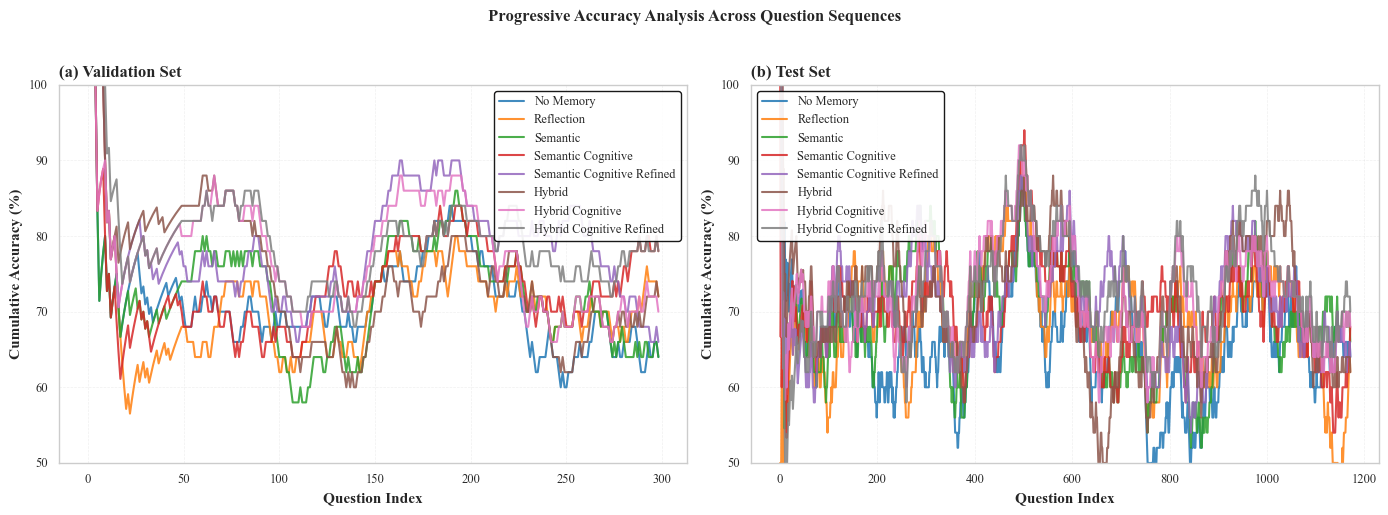


📈 Figura 1 gerada: Progressive Accuracy Analysis


In [67]:
# ============================================================================
# 2. ANÁLISE DE ACURÁCIA AO LONGO DAS QUESTÕES (PROGRESSIVE ACCURACY)
# ============================================================================

# Configurar estilo seaborn
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Configuração do estilo IEEE para gráficos
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'patch.linewidth': 1.0
})

# Calcular acurácia acumulada ao longo das questões
def calculate_rolling_accuracy(df, window=50):
    """Calcula acurácia móvel ao longo das questões"""
    return df['is_correct'].rolling(window=window, min_periods=1).mean() * 100

# Preparar dados para Validation Set
window_size = 50
rolling_data_valid = {}
for scenario_name, config in scenarios.items():
    _, valid_df, _, _ = config
    rolling_data_valid[scenario_name] = calculate_rolling_accuracy(valid_df, window=window_size)

# Preparar dados para Test Set
rolling_data_test = {}
for scenario_name, config in scenarios.items():
    test_df, _, _, _ = config
    rolling_data_test[scenario_name] = calculate_rolling_accuracy(test_df, window=window_size)

# Criar figura com dois subplots lado a lado (IEEE double-column style)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Progressive Accuracy Analysis Across Question Sequences', 
             fontweight='bold', y=1.02)

# Paleta de cores profissional
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f']

# Plot Validation Set
ax1 = axes[0]
for idx, (scenario_name, rolling_acc) in enumerate(rolling_data_valid.items()):
    ax1.plot(range(len(rolling_acc)), rolling_acc, 
            label=scenario_name, color=colors[idx % len(colors)],
            linewidth=1.5, alpha=0.85)

ax1.set_xlabel('Question Index', fontweight='bold')
ax1.set_ylabel('Cumulative Accuracy (%)', fontweight='bold')
ax1.set_title('(a) Validation Set', fontweight='bold', loc='left')
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(loc='best', framealpha=0.9, edgecolor='black')
ax1.set_ylim([50, 100])

# Plot Test Set
ax2 = axes[1]
for idx, (scenario_name, rolling_acc) in enumerate(rolling_data_test.items()):
    ax2.plot(range(len(rolling_acc)), rolling_acc, 
            label=scenario_name, color=colors[idx % len(colors)],
            linewidth=1.5, alpha=0.85)

ax2.set_xlabel('Question Index', fontweight='bold')
ax2.set_ylabel('Cumulative Accuracy (%)', fontweight='bold')
ax2.set_title('(b) Test Set', fontweight='bold', loc='left')
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(loc='best', framealpha=0.9, edgecolor='black')
ax2.set_ylim([50, 100])

plt.tight_layout()
plt.savefig('fig1_progressive_accuracy_ieee.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig1_progressive_accuracy_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📈 Figura 1 gerada: Progressive Accuracy Analysis")
sns.reset_defaults()

### 2.2 Gráfico de Linha com Suavização - Tendências de Acurácia

Versão suavizada do gráfico anterior usando média móvel, facilitando a identificação de tendências e padrões ao longo do conjunto de questões.

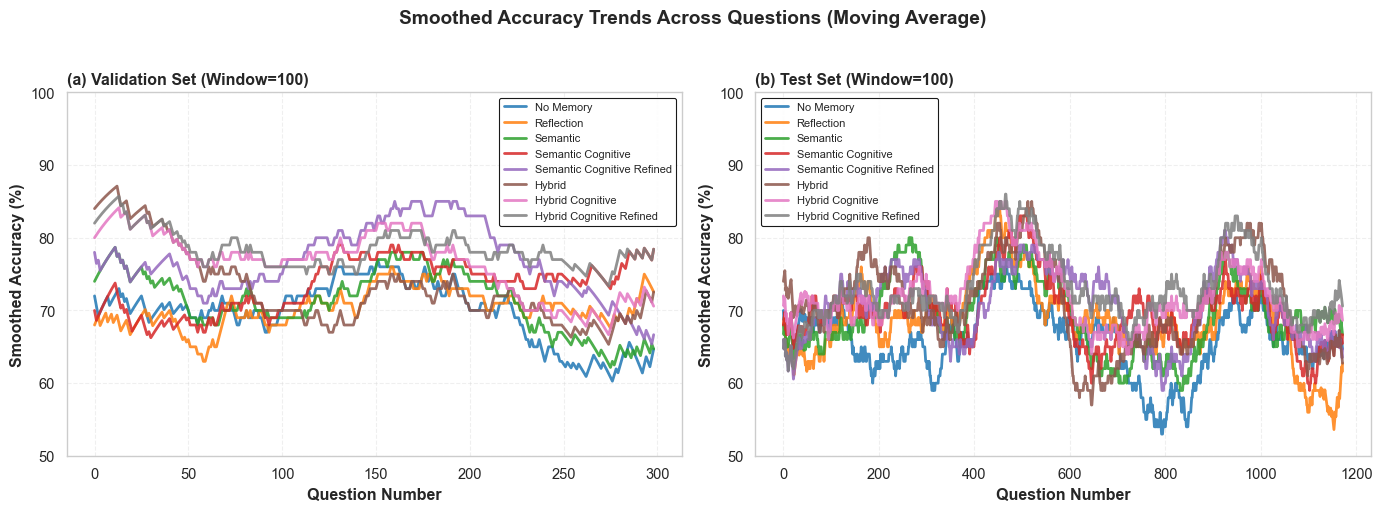


📈 Figura 1c gerada: Smoothed Accuracy Trends
   └─ Média móvel com janela de 100 questões
   └─ Facilita visualização de tendências e padrões gerais


In [68]:
# ============================================================================
# GRÁFICO DE LINHA SUAVIZADO: Tendências de Acurácia com Média Móvel
# ============================================================================

# Configurar estilo seaborn
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

def smooth_accuracy(accuracy_array, window=20):
    """Aplica média móvel para suavizar o gráfico"""
    return pd.Series(accuracy_array).rolling(window=window, min_periods=1, center=True).mean().values

# Criar figura com dois subplots (Validation e Test) - versão suavizada
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Smoothed Accuracy Trends Across Questions (Moving Average)', 
             fontweight='bold', y=1.02)

# Paleta de cores profissional
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f']

window_smooth = 100  # Janela de suavização

xlim = 50
ylim = 100

# Plot Validation Set - acurácia suavizada
ax1 = axes[0]
for idx, (scenario_name, config) in enumerate(scenarios.items()):
    _, valid_df, _, _ = config
    individual_acc_valid = valid_df['is_correct'].values * 100
    smoothed_acc = smooth_accuracy(individual_acc_valid, window=window_smooth)
    question_indices = range(len(smoothed_acc))
    
    ax1.plot(question_indices, smoothed_acc, 
            label=scenario_name, color=colors[idx % len(colors)],
            linewidth=2.0, alpha=0.85)

ax1.set_xlabel('Question Number', fontweight='bold')
ax1.set_ylabel('Smoothed Accuracy (%)', fontweight='bold')
ax1.set_title(f'(a) Validation Set (Window={window_smooth})', fontweight='bold', loc='left')
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.legend(loc='best', framealpha=0.9, edgecolor='black', fontsize=8)
ax1.set_ylim([xlim, ylim])

# Plot Test Set - acurácia suavizada
ax2 = axes[1]
for idx, (scenario_name, config) in enumerate(scenarios.items()):
    test_df, _, _, _ = config
    individual_acc_test = test_df['is_correct'].values * 100
    smoothed_acc = smooth_accuracy(individual_acc_test, window=window_smooth)
    question_indices = range(len(smoothed_acc))
    
    ax2.plot(question_indices, smoothed_acc, 
            label=scenario_name, color=colors[idx % len(colors)],
            linewidth=2.0, alpha=0.85)

ax2.set_xlabel('Question Number', fontweight='bold')
ax2.set_ylabel('Smoothed Accuracy (%)', fontweight='bold')
ax2.set_title(f'(b) Test Set (Window={window_smooth})', fontweight='bold', loc='left')
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(loc='best', framealpha=0.9, edgecolor='black', fontsize=8)
ax2.set_ylim([xlim, ylim])

plt.tight_layout()
plt.savefig('fig1c_smoothed_accuracy_trends_ieee.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig1c_smoothed_accuracy_trends_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Figura 1c gerada: Smoothed Accuracy Trends")
print(f"   └─ Média móvel com janela de {window_smooth} questões")
print("   └─ Facilita visualização de tendências e padrões gerais")
sns.reset_defaults()

## 3. Análise Estatística Individual de Métricas

Esta seção apresenta uma análise detalhada de cada métrica de desempenho, incluindo distribuições, intervalos de confiança e testes de significância estatística.

In [75]:
# ============================================================================
# 3.1 ANÁLISE ESTATÍSTICA: ACURÁCIA
# ============================================================================

def calculate_confidence_interval(data, confidence=0.95):
    """Calcula intervalo de confiança binomial para acurácia"""
    n = len(data)
    p = data.mean()
    z = stats.norm.ppf((1 + confidence) / 2)
    se = np.sqrt(p * (1 - p) / n)
    margin = z * se
    return p, margin, (p - margin, p + margin)

# Calcular estatísticas de acurácia
accuracy_stats = {
    'Sistema': [],
    'Valid Acc (%)': [],
    'Valid CI': [],
    'Test Acc (%)': [],
    'Test CI': [],
    'Δ (Test-Valid)': []
}

for scenario_name, config in scenarios.items():
    test_df, valid_df, _, _ = config
    
    # Calcular para Valid
    valid_acc, valid_margin, valid_ci = calculate_confidence_interval(valid_df['is_correct'])
    
    # Calcular para Test
    test_acc, test_margin, test_ci = calculate_confidence_interval(test_df['is_correct'])
    
    accuracy_stats['Sistema'].append(scenario_name)
    accuracy_stats['Valid Acc (%)'].append(f"{valid_acc*100:.2f}")
    accuracy_stats['Valid CI'].append(f"±{valid_margin*100:.2f}")
    accuracy_stats['Test Acc (%)'].append(f"{test_acc*100:.2f}")
    accuracy_stats['Test CI'].append(f"±{test_margin*100:.2f}")
    accuracy_stats['Δ (Test-Valid)'].append(f"{(test_acc - valid_acc)*100:+.2f}")

accuracy_df = pd.DataFrame(accuracy_stats)
print("="*100)
print("TABELA I")
print("ANÁLISE ESTATÍSTICA DE ACURÁCIA COM INTERVALOS DE CONFIANÇA (95%)")
print("="*100)
print(accuracy_df.to_string(index=False))
print("="*100)
print("\n📊 Interpretação:")
print("• CI (Confidence Interval): Margem de erro com 95% de confiança")
print("• Δ: Diferença entre Test e Validation (valores negativos indicam overfitting)")
print("\n")

TABELA I
ANÁLISE ESTATÍSTICA DE ACURÁCIA COM INTERVALOS DE CONFIANÇA (95%)
                   Sistema Valid Acc (%) Valid CI Test Acc (%) Test CI Δ (Test-Valid)
                 No Memory         69.57    ±5.22        65.96   ±2.71          -3.61
                Reflection         70.23    ±5.18        68.86   ±2.65          -1.38
                  Semantic         70.90    ±5.15        69.28   ±2.64          -1.62
        Semantic Cognitive         73.58    ±5.00        70.05   ±2.62          -3.53
Semantic Cognitive Refined         76.59    ±4.80        70.65   ±2.61          -5.94
                    Hybrid         72.91    ±5.04        70.99   ±2.60          -1.92
          Hybrid Cognitive         76.25    ±4.82        72.01   ±2.57          -4.24
  Hybrid Cognitive Refined         78.26    ±4.68        73.12   ±2.54          -5.14

📊 Interpretação:
• CI (Confidence Interval): Margem de erro com 95% de confiança
• Δ: Diferença entre Test e Validation (valores negativos indicam ove

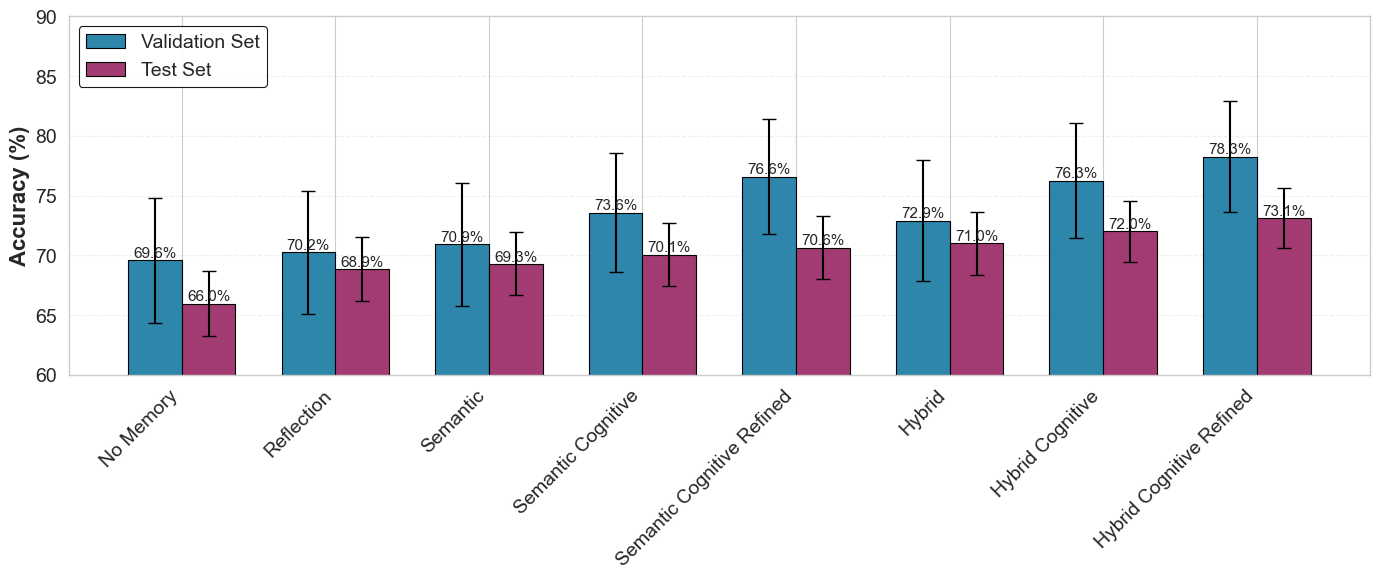


📈 Figura 2 gerada: Comparative Accuracy Analysis


In [76]:
# ============================================================================
# GRÁFICO: Comparação de Acurácia com Intervalos de Confiança
# ============================================================================

# Preparar dados para plotagem
systems = list(scenarios.keys())
valid_accs = []
valid_errors = []
test_accs = []
test_errors = []

for scenario_name, config in scenarios.items():
    test_df, valid_df, _, _ = config
    
    valid_acc, valid_margin, _ = calculate_confidence_interval(valid_df['is_correct'])
    test_acc, test_margin, _ = calculate_confidence_interval(test_df['is_correct'])
    
    valid_accs.append(valid_acc * 100)
    valid_errors.append(valid_margin * 100)
    test_accs.append(test_acc * 100)
    test_errors.append(test_margin * 100)

# Criar DataFrame para seaborn
plot_data = []
for i, system in enumerate(systems):
    plot_data.append({'System': system, 'Dataset': 'Validation', 'Accuracy': valid_accs[i], 'Error': valid_errors[i]})
    plot_data.append({'System': system, 'Dataset': 'Test', 'Accuracy': test_accs[i], 'Error': test_errors[i]})
plot_df = pd.DataFrame(plot_data)

# Configurar estilo seaborn
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

# Criar gráfico de barras agrupadas com seaborn
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(systems))
width = 0.35

bars1 = ax.bar(x - width/2, valid_accs, width, yerr=valid_errors,
               label='Validation Set', color='#2E86AB', 
               edgecolor='black', linewidth=0.8,
               capsize=5, error_kw={'linewidth': 1.5})

bars2 = ax.bar(x + width/2, test_accs, width, yerr=test_errors,
               label='Test Set', color='#A23B72',
               edgecolor='black', linewidth=0.8,
               capsize=5, error_kw={'linewidth': 1.5})

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(systems, rotation=45, ha='right', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='upper left', framealpha=0.9, edgecolor='black', fontsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_ylim([60, 90])

# Adicionar valores no topo das barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('fig2_accuracy_comparison_ieee.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig2_accuracy_comparison_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📈 Figura 2 gerada: Comparative Accuracy Analysis")
sns.reset_defaults()

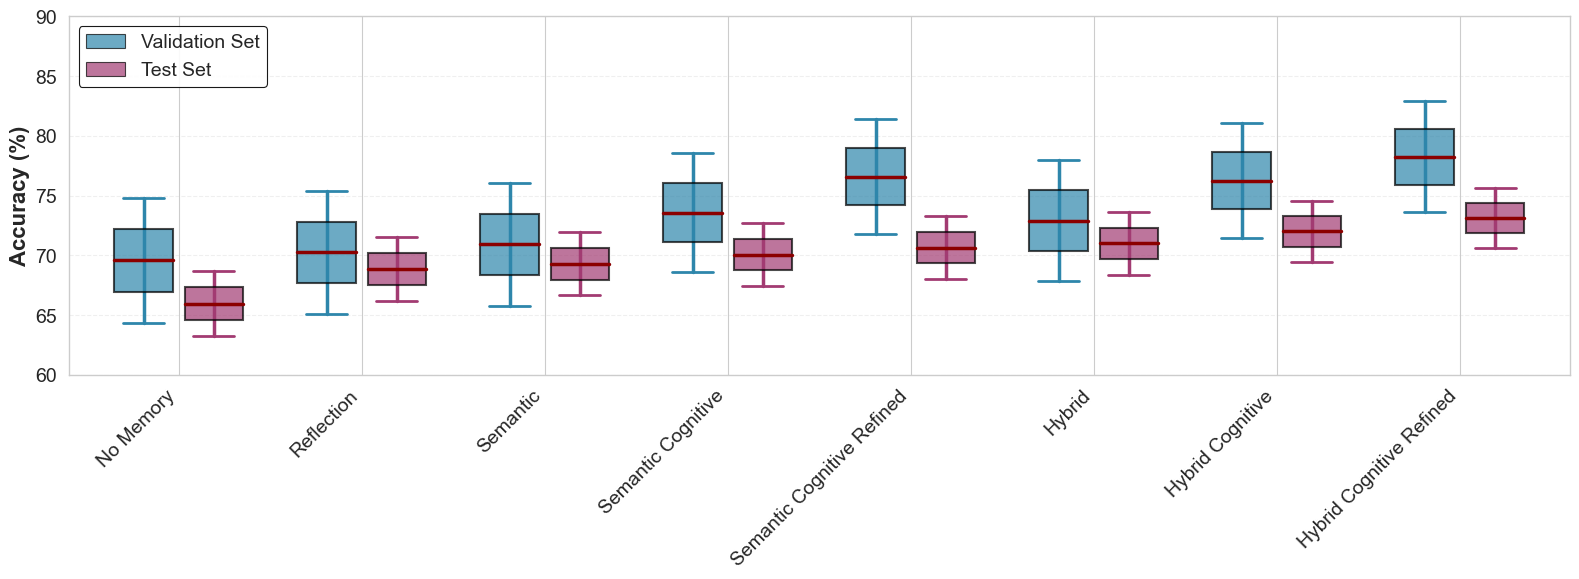


📈 Figura 3 gerada: Boxplot-style agrupado com Intervalos de Confiança (95%)
   └─ Box: 50% do IC | Whiskers: Limites do IC | Linha vermelha: Média
   └─ Azul: Validation | Roxo: Test


In [77]:
# ============================================================================
# GRÁFICO BOXPLOT-STYLE: Distribuição de Acurácia com Intervalos de Confiança
# ============================================================================

# Configurar estilo seaborn
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)

# Preparar dados - usar intervalos de confiança ao invés de distribuição binária
systems = list(scenarios.keys())
valid_means = []
valid_ci_lower = []
valid_ci_upper = []
test_means = []
test_ci_lower = []
test_ci_upper = []

for scenario_name, config in scenarios.items():
    test_df, valid_df, _, _ = config
    
    # Calcular intervalos de confiança
    valid_acc, valid_margin, (valid_lower, valid_upper) = calculate_confidence_interval(valid_df['is_correct'])
    test_acc, test_margin, (test_lower, test_upper) = calculate_confidence_interval(test_df['is_correct'])
    
    valid_means.append(valid_acc * 100)
    valid_ci_lower.append(valid_lower * 100)
    valid_ci_upper.append(valid_upper * 100)
    
    test_means.append(test_acc * 100)
    test_ci_lower.append(test_lower * 100)
    test_ci_upper.append(test_upper * 100)

# Criar figura com boxplots agrupados
fig, ax = plt.subplots(figsize=(16, 6))

# Configurar posições - cada sistema tem 2 boxes (Validation e Test)
n_systems = len(systems)
group_width = 0.8
box_width = group_width / 2.5
offset = box_width * 0.6

x_positions = np.arange(n_systems)

# Plot Validation Set (azul) - posição à esquerda
for i in range(n_systems):
    x = x_positions[i] - offset
    
    # Desenhar linha vertical (range do CI)
    ax.plot([x, x], [valid_ci_lower[i], valid_ci_upper[i]], 
            color='#2E86AB', linewidth=2.5, zorder=1)
    
    # Desenhar caixas (box) ao redor da média
    box_height = (valid_ci_upper[i] - valid_ci_lower[i]) * 0.5
    box_center = valid_means[i]
    rect = plt.Rectangle((x - box_width/2, box_center - box_height/2), box_width, box_height,
                         facecolor='#2E86AB', edgecolor='black', linewidth=1.5, alpha=0.7)
    ax.add_patch(rect)
    
    # Desenhar linha da mediana/média
    ax.plot([x - box_width/2, x + box_width/2], [valid_means[i], valid_means[i]], 
            color='darkred', linewidth=2.5, zorder=3)
    
    # Desenhar caps (whiskers)
    cap_width = box_width * 0.7
    ax.plot([x - cap_width/2, x + cap_width/2], [valid_ci_lower[i], valid_ci_lower[i]], 
            color='#2E86AB', linewidth=2, zorder=2)
    ax.plot([x - cap_width/2, x + cap_width/2], [valid_ci_upper[i], valid_ci_upper[i]], 
            color='#2E86AB', linewidth=2, zorder=2)

# Plot Test Set (roxo) - posição à direita
for i in range(n_systems):
    x = x_positions[i] + offset
    
    # Desenhar linha vertical (range do CI)
    ax.plot([x, x], [test_ci_lower[i], test_ci_upper[i]], 
            color='#A23B72', linewidth=2.5, zorder=1)
    
    # Desenhar caixas (box) ao redor da média
    box_height = (test_ci_upper[i] - test_ci_lower[i]) * 0.5
    box_center = test_means[i]
    rect = plt.Rectangle((x - box_width/2, box_center - box_height/2), box_width, box_height,
                         facecolor='#A23B72', edgecolor='black', linewidth=1.5, alpha=0.7)
    ax.add_patch(rect)
    
    # Desenhar linha da mediana/média
    ax.plot([x - box_width/2, x + box_width/2], [test_means[i], test_means[i]], 
            color='darkred', linewidth=2.5, zorder=3)
    
    # Desenhar caps (whiskers)
    cap_width = box_width * 0.7
    ax.plot([x - cap_width/2, x + cap_width/2], [test_ci_lower[i], test_ci_lower[i]], 
            color='#A23B72', linewidth=2, zorder=2)
    ax.plot([x - cap_width/2, x + cap_width/2], [test_ci_upper[i], test_ci_upper[i]], 
            color='#A23B72', linewidth=2, zorder=2)

# Configurar eixos e labels
ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=16)
ax.set_xticks(x_positions)
ax.set_xticklabels(systems, rotation=45, ha='right', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.set_ylim([60, 90])
ax.set_xlim([-0.6, n_systems - 0.4])

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', edgecolor='black', label='Validation Set', alpha=0.7),
    Patch(facecolor='#A23B72', edgecolor='black', label='Test Set', alpha=0.7)
]
ax.legend(handles=legend_elements, loc='upper left', framealpha=0.9, 
         edgecolor='black', fontsize=14)

plt.tight_layout()
plt.savefig('fig3_boxplot_accuracy_comparison_ieee.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig3_boxplot_accuracy_comparison_ieee.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📈 Figura 3 gerada: Boxplot-style agrupado com Intervalos de Confiança (95%)")
print("   └─ Box: 50% do IC | Whiskers: Limites do IC | Linha vermelha: Média")
print("   └─ Azul: Validation | Roxo: Test")
sns.reset_defaults()